# Tâche #1 : Classification d'incidents avec un réseau *feedforward* et des *embeddings* Spacy

On reprend la classification des descriptions d’accidents du premier travail. Le corpus de textes contient 3 partitions : 
-	un fichier d’entraînement -  data/incidents_train.json
-	un fichier de validation -  data/incidents_dev.json
-	un fichier de test - data/incidents_test.json

Entraînez un modèle de réseau de neurones de type feedforward multicouche (MLP) avec plongements de mots pour déterminer le type d’un incident à partir de sa description. 

Voici les consignes pour cette tâche : 

-	Nom du notebook : mlp.ipynb
-	Tokenisation : Utilisation de Spacy. 
-	Plongements de mots : Ceux de Spacy. 
-	Normalisation : Aucune normalisation. 
-	Agrégation des plongements de mots : Comparer les approches max, average et min pooling. 
-	Structure du réseau : 1 seule couche cachée dont vous choisirez la taille (à expliquer). 
-	Présentez clairement vos résultats et faites-en l’analyse. En cas de doute, inspirez-vous de ce qui a été fait dans le travail pratique #1. 

Vous pouvez ajouter au *notebook* toutes les cellules dont vous avez besoin pour votre code, vos explications ou la présentation de vos résultats. Vous pouvez également ajouter des sous-sections (par ex. des sous-sections 1.1, 1.2 etc.) si cela améliore la lisibilité.

Notes :
- Évitez les bouts de code trop longs ou trop complexes. Par exemple, il est difficile de comprendre 4-5 boucles ou conditions imbriquées. Si c'est le cas, définissez des sous-fonctions pour refactoriser et simplifier votre code. 
- Expliquez sommairement votre démarche.
- Expliquez les choix que vous faites au niveau de la programmation et des modèles (si non trivial).
- Analyser vos résultats. Indiquez ce que vous observez, si c'est bon ou non, si c'est surprenant, etc. 
- Une analyse quantitative et qualitative d'erreurs est intéressante et permet de mieux comprendre le comportement d'un modèle. 

## 1. Création du jeu de données (*dataset*)

In [1]:
import spacy

spacy_model = spacy.load("en_core_web_md")

In [2]:
import json
import numpy as np

# Définition des chemins vers les fichiers de données
train_data_path = './data/incidents_train.json'
dev_data_path = './data/incidents_dev.json'
test_data_path = './data/incidents_test.json'

def load_incident_dataset(filename):
    with open(filename, 'r') as fp:
        incident_list = json.load(fp)
        
        text = [item["text"] for item in incident_list]
        target = np.array([int(item["label"]) for item in incident_list])
         
    return text, target


# Créer les DataFrames pour chaque partition de données
train_list, train_target = load_incident_dataset(train_data_path)
dev_list, dev_target = load_incident_dataset(dev_data_path)
test_list, test_target = load_incident_dataset(test_data_path)

# Affichage de l'information de base sur les DataFrames
display(f"Train data: text_size {len(train_list)}, target_size {len(train_target)}")
display(f"Dev data: text_size {len(dev_list)}, target_size {len(dev_target)}")
display(f"Test data: text_size {len(test_list)}, target_size {len(test_target)}")



# Vérification des premiers enregistrements dans l'ensemble d'entraînement
train_list[0]


'Train data: text_size 2475, target_size 2475'

'Dev data: text_size 531, target_size 531'

'Test data: text_size 531, target_size 531'

' At approximately 8:50 a.m. on October 29  1997  Employee #1 was painting a  single story house at 2657 7th Ave  Sacramento  CA. He was caulking around the  peak of the roof line on the west side of the house  20 ft above the ground.  He was working off of a 24 ft aluminum extension ladder so that his feet were  approximately 12 to 13 feet above the ground. Employee #1 fell and suffered a  concussion and two dislocated discs in his lower back and was hospitalized.  The ladder was not secured to prevent movement.                                 '

Ce script utilise les bibliothèques json et numpy pour manipuler les données. Il charge les données d'incidents à partir de fichiers JSON, les organise dans des ensembles de textes et d'étiquettes, crée des DataFrames pour chaque ensemble de données, affiche des informations de base sur ces ensembles, puis vérifie le premier enregistrement dans l'ensemble d'entraînement. 

## 2. Gestion de plongements de mots (*embeddings*)

In [118]:
# Création des plongements de mots pour chaque séquence du dataset d'entrainement

docs = []
for train in train_list:
    docs.append(spacy_model(train))

In [3]:
import numpy as np

# Cette section consiste a prendre le plongement de chaque mot d'une séquence
# et de les combiner pour avoir un seul vecteur représentant la séquence complete.
# Différents moyens de combinaison sont utilisés: average, min et max.

# Fonction pour calculer l'embedding moyen d'une phrase
def average_embedding(sentence, nlp_model=spacy_model):
    tokenised_sentence = nlp_model(sentence)      # Tokenisation de la phrase
    nb_column = len(tokenised_sentence)     # Nombre de colonnes dans la matrice d'embedding (nombre de tokens)
    nb_rows =  nlp_model.vocab.vectors_length  # Nombre de lignes dans la matrice d'embedding (taille de l'espace d'embedding)
    sentence_embedding_matrix = np.zeros((nb_rows, nb_column))                                  
    for index, token in enumerate(tokenised_sentence):  # Remplissage de la matrice d'embedding avec les vecteurs d'embedding de chaque token
        sentence_embedding_matrix[:, index] = token.vector
    return np.average(sentence_embedding_matrix, axis=1)  # Calcul de l'embedding moyen en prenant la moyenne le long de l'axe des colonnes

# Fonction pour calculer l'embedding avec la technique du max pooling d'une phrase
def maxpool_embedding(sentence, nlp_model=spacy_model): 
    tokenised_sentence = nlp_model(sentence)
    nb_column = len(tokenised_sentence)
    nb_rows =  nlp_model.vocab.vectors_length 
    sentence_embedding_matrix = np.zeros((nb_rows, nb_column))                                    
    for index, token in enumerate(tokenised_sentence):
        sentence_embedding_matrix[:, index] = token.vector
    return np.max(sentence_embedding_matrix, axis=1)

# Fonction pour calculer l'embedding avec la technique du min pooling d'une phrase
def minpool_embedding(sentence, nlp_model=spacy_model):
    tokenised_sentence = nlp_model(sentence)
    nb_column = len(tokenised_sentence)
    nb_rows =  nlp_model.vocab.vectors_length 
    sentence_embedding_matrix = np.zeros((nb_rows, nb_column))                                    
    for index, token in enumerate(tokenised_sentence):
        sentence_embedding_matrix[:, index] = token.vector
    return np.min(sentence_embedding_matrix, axis=1)

Ces fonctions prennent une phrase en entrée, la tokenisent à l'aide d'un modèle spaCy (nlp_model), puis calculent l'embedding moyen, l'embedding avec la technique du max pooling, ou l'embedding avec la technique du min pooling en utilisant les vecteurs d'embedding des tokens.

In [5]:
# Exemple du plongement de la 1ere séquence du dataset d'entrainement avec le average_embedding

display(len(average_embedding(train_list[0]))) # Taille du vecteur

display(average_embedding(train_list[0])) # Valeurs

300

array([-1.96873228e+00, -5.10729270e-01, -2.35349378e+00,  4.97672888e-01,
        4.88353263e+00, -5.49114923e-01,  5.77439719e-01,  4.37476939e+00,
        9.82608505e-01,  2.76181211e-01,  3.32291929e+00,  1.83452836e+00,
       -2.19539340e+00,  7.13141577e-01,  4.67925282e-01,  1.69569208e+00,
       -4.15554943e-01,  5.46220097e-01, -8.17133067e-01, -1.81754243e+00,
        1.45045962e+00, -1.64859988e-01,  7.35189274e-01,  1.39185669e+00,
       -2.16275255e-01, -1.53836771e+00, -2.90574922e+00, -1.10088644e+00,
       -2.45176188e-01,  1.23890522e+00,  7.16629948e-01,  2.70870438e-01,
       -4.62952329e-01, -2.58849184e+00, -2.63352788e+00, -1.38033428e+00,
       -6.32679274e-01,  1.24110528e+00,  4.78200293e-01,  2.11488465e-02,
        1.16837779e+00, -2.70511874e-01, -1.43659251e-01,  9.54270908e-01,
       -1.01153907e+00,  1.14068031e+00,  1.59027040e-01, -2.24387173e-01,
       -2.60219337e-03,  1.40369611e+00, -4.18182354e-01,  1.69740604e+00,
       -1.48766517e+00, -

## 3. Création de modèle(s)

In [6]:
from torch import nn


class MultiLayerPerceptron(nn.Module):
    # Initialisation du modèle avec les paramètres d'entrée, de la couche cachée et de sortie
    def __init__(self, input_size, hidden_layer_size, output_size) :
        super().__init__()
        self.intput_layer = nn.Linear(input_size, hidden_layer_size)  # Définition de la couche d'entrée (input layer) avec une transformation linéaire
        self.output_layer = nn.Linear(hidden_layer_size, output_size) # Définition de la couche de sortie (output layer) avec une transformation linéaire
        
    def forward(self, x):
        x = self.intput_layer(x)
        x = nn.functional.relu_(x)
        x = self.output_layer(x)
        return x

Cette classe MultiLayerPerceptron hérite de la classe "nn.Module" de PyTorch et définit un modèle de perceptron multicouche avec une couche d'entrée, une couche cachée avec une fonction d'activation ReLU, et une couche de sortie. La méthode "forward" spécifie comment les données passent à travers le modèle lors de l'inférence.

In [7]:
from torch.utils.data import Dataset, DataLoader
from torch import FloatTensor, LongTensor
from typing import List

class SpacyDataset(Dataset):
    # Initialisation de la classe avec les données du dataset, les cibles, et une fonction d'agrégation des phrases
    def __init__(self, dataset: List[str] , target: np.array, sentence_aggregation_function):
        self.dataset = dataset
        self.doc_embeddings = [None for _ in range(len(dataset))] # Initialisation d'une liste vide pour stocker les embeddings des phrases(spaCy)
        self.sentence_aggregation_function = sentence_aggregation_function # Stockage de la fonction d'agrégation des phrases
        self.target = target
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        if self.doc_embeddings[index] is None:
            self.doc_embeddings[index] = self.sentence_aggregation_function(self.dataset[index])  
        return FloatTensor(self.doc_embeddings[index]), LongTensor([self.target[index]]).squeeze(0)

In [8]:
# Un dictionnaire pour choisir le type d'agrégation
aggregation = {
    "average" : average_embedding,
    "maxpool" : maxpool_embedding,
    "minpool" : minpool_embedding
}

# On détermine ici comment la classe SpacyDataset construit la représentation d'un texte
# par l'agrégation des représentations de mots. 
# Choix possibles: "average", "maxpool", "minpool"
aggregation_function = aggregation["average"] 

Ce code utilise un dictionnaire appelé 'aggregation' pour associer des chaînes de caractères à des fonctions d'agrégation, telles que 'average_embedding', 'maxpool_embedding' et 'minpool_embedding'. Ensuite, il sélectionne une fonction d'agrégation spécifique (dans cet exemple, "average") pour être utilisée dans la construction des ensembles de données (train_dataset, valid_dataset, test_dataset) en utilisant la classe SpacyDataset, ainsi que leurs DataLoaders respectifs (train_dataloader, valid_dataloader, test_dataloader). Les DataLoaders sont utilisés pour simplifier l'itération sur les ensembles de données lors de l'entraînement et de l'évaluation du modèle.

## 4. Fonctions utilitaires

La fonction train est utilisée pour entraîner le modèle de classification à l'aide de la bibliothèque Poutyne, qui est une surcouche (wrapper) pour PyTorch pour simplifier le processus d'entraînement des modèles. Il crée un modèle MLP avec les paramètres spécifiés, puis utilise la classe 'Experiment' de Poutyne pour superviser l'entraînement et l'évaluation du modèle. Le répertoire spécifié (directory_name) sera employé pour stocker le modèle et les résultats de l'expérience.

Après de nombreux essais, il a été concclu que la taille de la couche cachée de 100 est la meilleure option pour cette tâche de classification en raison de son équilibre entre la capacité du modèle à apprendre des motifs complexes et sa capacité à généraliser à partir des données 

In [45]:
from poutyne.framework import Experiment
from poutyne import set_seeds
from torch.optim import SGD
import numpy as np

def train(nb_epochs=50, hidden_size=100, optimizer="SGD", aggregation_function=aggregation["average"], embedding_size=spacy_model.meta['vectors']['width'], nb_classes = len([i for i in range(9)]), ):

    print("Taille des plongements de Spacy:", embedding_size)
    print("Nombre de classes:", nb_classes)

    # On finalise la construction des 3 jeux de données et leurs dataloaders
    train_dataset = SpacyDataset(train_list, train_target, aggregation_function)
    valid_dataset = SpacyDataset(dev_list, dev_target, aggregation_function)
    test_dataset = SpacyDataset(test_list, test_target, aggregation_function)

    # Création des dataloaders pour l'entrainement
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

    set_seeds(42) # Fixation des graines pour assurer la reproductibilité

    directory_name = 'model_task1/{}'.format(aggregation_function.__name__)
    # directory_name = 'model_task1/{}_mlp_optimizer{}'.format(aggregation_function.__name__, optimizer)  

    # Création du modèle MLP
    model = MultiLayerPerceptron(embedding_size, hidden_size, nb_classes)

    # Création d'une instance de la classe Experiment de Poutyne pour gérer l'entraînement et l'évaluation
    experiment = Experiment(directory_name, 
                        model, 
                        optimizer = optimizer, 
                        task="classification")
    print(model)
    
    # On lance l'entrainement du model
    logging = experiment.train(train_dataloader, valid_dataloader, epochs=nb_epochs, disable_tensorboard=True)

    return model, experiment, test_dataloader, logging

La fonction evaluate est utilisée pour évaluer un modèle après l'entraînement en utilisant la bibliothèque IPython.display pour afficher des graphiques d'évaluation.

In [50]:
from IPython.display import Image

def evaluate(experiment, test_dataloader):
    # Test the model on the test dataset
    experiment.test(test_dataloader)

    # Specify the path to your PNG image file
    directory = f"{experiment.directory}/plots"

    acc = f"{directory}/acc.png"
    f1 = f"{directory}/fscore_macro.png"
    loss = f"{directory}/loss.png"

    # Display the PNG image
    display(Image(filename=acc), Image(filename=f1), Image(filename=loss))

## 5. Entraînement de modèle(s)

Ce code utilise les métadonnées du modèle spaCy pour extraire la dimension des vecteurs d'embedding (embedding_size). Ensuite, il détermine le nombre de classes (nb_classes) en comptant le nombre d'entiers dans la plage de 0 à 8. Enfin, il affiche ces informations. Il est important de noter que dans cet exemple, le nombre de classes est fixé à 9.

### Training avec average pooling

In [51]:
average_pooling_model, average_experiment, average_test_dataloader, average_logging  = train(aggregation_function=aggregation["average"])

Taille des plongements de Spacy: 300
Nombre de classes: 9
MultiLayerPerceptron(
  (intput_layer): Linear(in_features=300, out_features=100, bias=True)
  (output_layer): Linear(in_features=100, out_features=9, bias=True)
)
Loading weights from model_task1/average_embedding/checkpoint.ckpt and starting at epoch 51.
Loading optimizer state from model_task1/average_embedding/checkpoint.optim and starting at epoch 51.
Loading random states from model_task1/average_embedding/checkpoint.randomstate and starting at epoch 51.
Restoring data from model_task1/average_embedding/checkpoint_epoch_45.ckpt


### Training avec min pooling

In [53]:
min_pooling_model, min_experiment, min_test_dataloader, min_logging  = train(aggregation_function=aggregation["minpool"])


Taille des plongements de Spacy: 300
Nombre de classes: 9
MultiLayerPerceptron(
  (intput_layer): Linear(in_features=300, out_features=100, bias=True)
  (output_layer): Linear(in_features=100, out_features=9, bias=True)
)
Epoch:  1/50 Train steps: 155 Val steps: 34 57.36s loss: 2.255475 acc: 34.060606 fscore_macro: 0.083219 val_loss: 1.988780 val_acc: 12.429379 val_fscore_macro: 0.026802
Epoch 1: val_acc improved from -inf to 12.42938, saving file to model_task1/minpool_embedding/checkpoint_epoch_1.ckpt
Epoch:  2/50 Train steps: 155 Val steps: 34 0.18s loss: 1.853832 acc: 36.929293 fscore_macro: 0.069661 val_loss: 2.066507 val_acc: 39.548023 val_fscore_macro: 0.062978
Epoch 2: val_acc improved from 12.42938 to 39.54802, saving file to model_task1/minpool_embedding/checkpoint_epoch_2.ckpt
Epoch:  3/50 Train steps: 155 Val steps: 34 0.17s loss: 2.009708 acc: 38.707071 fscore_macro: 0.062012 val_loss: 1.959643 val_acc: 39.548023 val_fscore_macro: 0.062978
Epoch:  4/50 Train steps: 155 Val

### Training avec max pooling

In [55]:
max_pooling_model, max_experiment, max_test_dataloader, max_logging  = train(aggregation_function=aggregation["maxpool"])


Taille des plongements de Spacy: 300
Nombre de classes: 9
MultiLayerPerceptron(
  (intput_layer): Linear(in_features=300, out_features=100, bias=True)
  (output_layer): Linear(in_features=100, out_features=9, bias=True)
)
Epoch:  1/50 Train steps: 155 Val steps: 34 58.01s loss: 2.174021 acc: 33.939394 fscore_macro: 0.080416 val_loss: 2.109830 val_acc: 39.736347 val_fscore_macro: 0.065817
Epoch 1: val_acc improved from -inf to 39.73635, saving file to model_task1/maxpool_embedding/checkpoint_epoch_1.ckpt
Epoch:  2/50 Train steps: 155 Val steps: 34 0.17s loss: 1.834501 acc: 36.484848 fscore_macro: 0.084407 val_loss: 2.082083 val_acc: 39.548023 val_fscore_macro: 0.063063
Epoch:  3/50 Train steps: 155 Val steps: 34 0.17s loss: 1.854253 acc: 36.404040 fscore_macro: 0.076750 val_loss: 1.929380 val_acc: 16.384181 val_fscore_macro: 0.031284
Epoch:  4/50 Train steps: 155 Val steps: 34 0.24s loss: 1.939051 acc: 38.101010 fscore_macro: 0.064247 val_loss: 1.743037 val_acc: 39.548023 val_fscore_mac

## 6. Évaluation et analyse de résultats

### Evaluation de average pooling

Found best checkpoint at epoch: 45
lr: 0.01, loss: 0.773051, acc: 72.8081, fscore_macro: 0.586379, val_loss: 0.892524, val_acc: 70.0565, val_fscore_macro: 0.539081
Loading checkpoint model_task1/average_embedding/checkpoint_epoch_45.ckpt
Running test
Test steps: 34 10.06s test_loss: 0.889889 test_acc: 69.114878 test_fscore_macro: 0.543526   


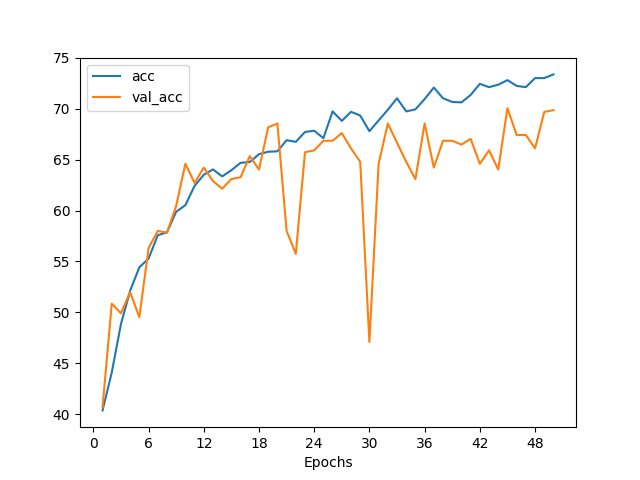

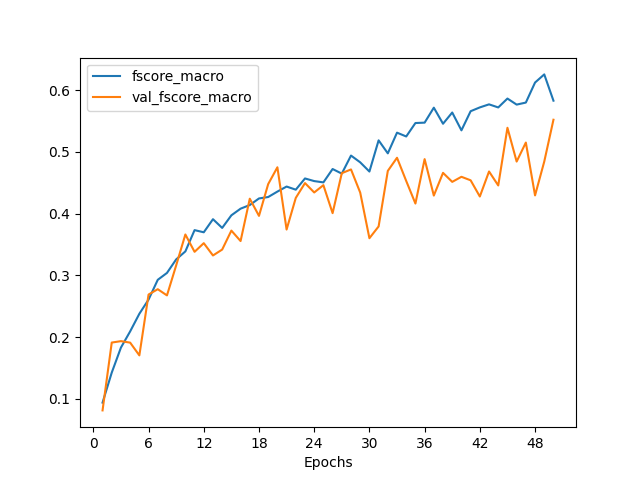

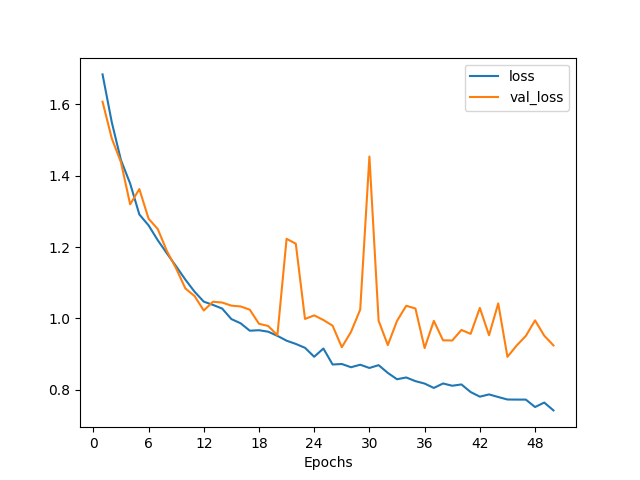

In [52]:
# Évaluation du modèle sur l'ensemble de test à l'aide du DataLoader test_dataloader

evaluate(average_experiment, average_test_dataloader)

### Evaluation de min pooling

Found best checkpoint at epoch: 36
lr: 0.01, loss: 1.6412, acc: 42.7475, fscore_macro: 0.11903, val_loss: 1.6298, val_acc: 45.0094, val_fscore_macro: 0.12171
Loading checkpoint model_task1/minpool_embedding/checkpoint_epoch_36.ckpt
Running test
Test steps: 34 10.35s test_loss: 1.699124 test_acc: 38.794727 test_fscore_macro: 0.108423    


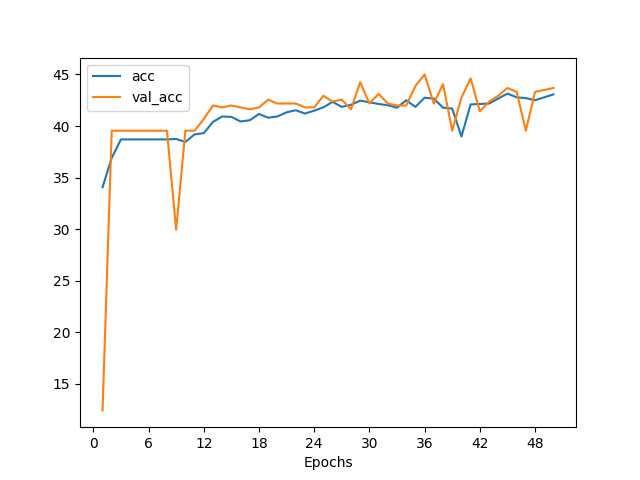

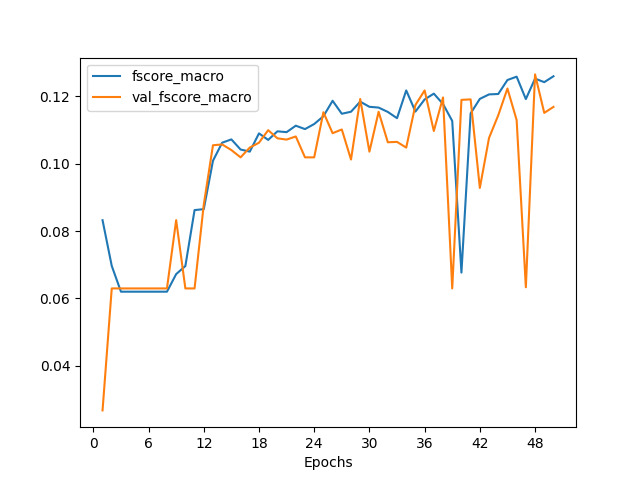

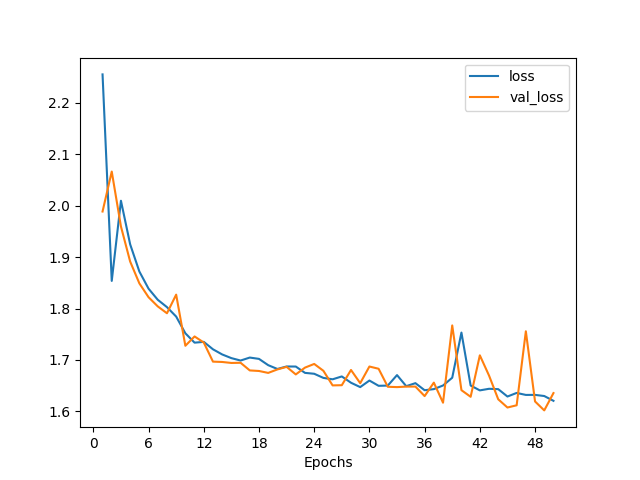

In [54]:
# Évaluation du modèle sur l'ensemble de test à l'aide du DataLoader test_dataloader

evaluate(min_experiment, min_test_dataloader)

### Evaluation de max pooling

Found best checkpoint at epoch: 7
lr: 0.01, loss: 1.75995, acc: 38.2222, fscore_macro: 0.0721154, val_loss: 1.66148, val_acc: 40.678, val_fscore_macro: 0.0897715
Loading checkpoint model_task1/maxpool_embedding/checkpoint_epoch_7.ckpt
Running test
Test steps: 34 10.40s test_loss: 1.712957 test_acc: 38.606403 test_fscore_macro: 0.103834    


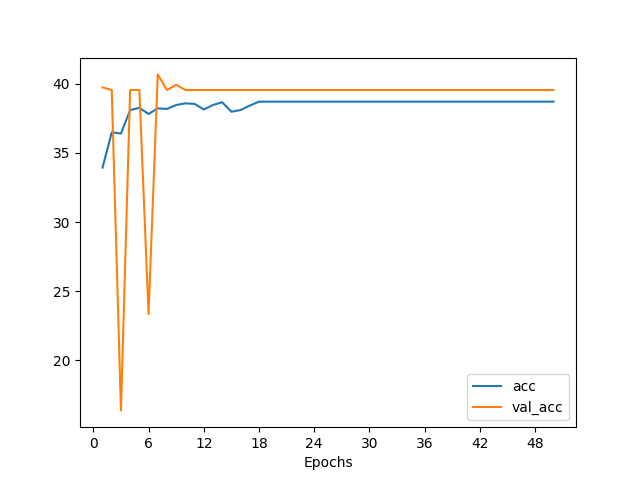

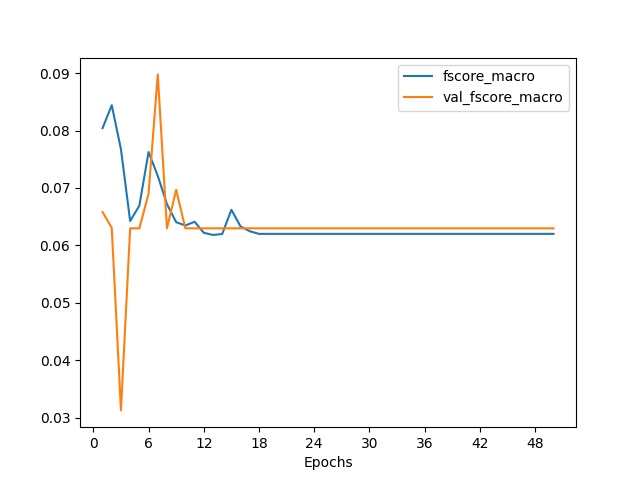

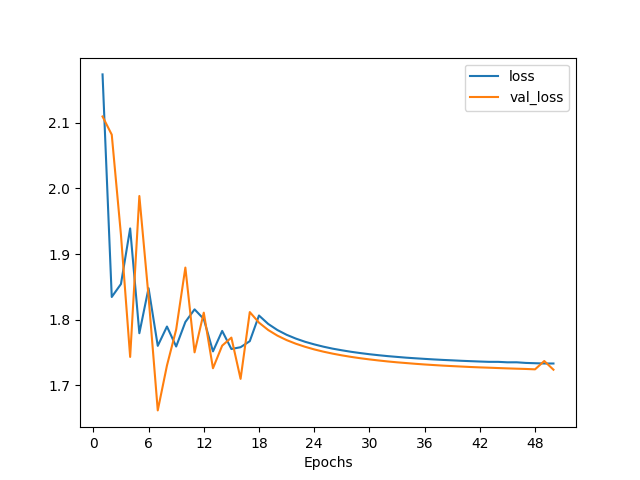

In [56]:
# Évaluation du modèle sur l'ensemble de test à l'aide du DataLoader test_dataloader

evaluate(max_experiment, max_test_dataloader)

## Analyse des resultats

Analysons les résultats pour chaque méthode de pooling :

Average Pooling :

- Précision (Accuracy) : 69.11%;
Score F1 Macro : 54.35%;
Perte (Loss) : 0.8899

Min Pooling :

- Précision (Accuracy) : 38.79%;
Score F1 Macro : 10.84%;
Perte (Loss) : 1.6991

Max Pooling :

- Précision (Accuracy) : 38.61%;
Score F1 Macro : 10.38%;
Perte (Loss) : 1.7129

L'average pooling obtient la meilleure précision (69.11%) et le meilleur score F1 Macro (54.35%) parmi les trois méthodes de pooling. De plus, il présente la plus faible perte (0.8899), ce qui indique une bonne performance globale.

En revanche, le min pooling et le max pooling ont des performances considérablement plus faibles. Ils ont des précisions similaires d'environ 38-39%, ce qui est nettement inférieur à l'average pooling. Le score F1 Macro est également très bas, aux alentours de 10%. De plus, les deux méthodes de pooling ont des pertes élevées, dépassant 1.7, ce qui indique une mauvaise capacité à apprendre des données.

Ces résultats montrent que l'average pooling est de loin la méthode la plus performante parmi les trois options de pooling. Le min pooling et le max pooling présentent des performances nettement inférieures. Ces résultats ne sont pas surprenants, car l'average pooling a tendance à mieux préserver les informations utiles dans les données par rapport au min et au max pooling